# Common Neural Network Architecture Tweaks and Training Techniques

This tutorial will cover some common practices to follow when designing training Neural Networks. These will include:

- **Skip connections**: Connections that bypass the classic-sequential architecture of Neural Networks to connect non-consecutive layers.
- **Dropout**: An operation that is applied to a layer and acts as a regularizer.
- **Batch Normalization**: An operation that, again, is applied to a layer and helps stabilize and speed up the optimization process.
- **Data augmentation**: A series of techniques that effectively increase the size of the training set.


## Warning

This notebook requires longer training times than the previous ones. Make sure you are running on GPU acceleration. Cells might take several minutes to run.

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
import imgaug as ia


import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)


For this tutorial we'll use the [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is significantly harder than the ones we've seen up till now, to better showcase the benefits of these techniques.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

## Skip Connections

A typical Neural Network's structure is purely sequential, meaning that the output of the first layer is fed to the second, the output of the second is fed to the thrid and so on...

Skip connections attempt to bypass this sequential flow. The goal of these is to connect a given layer with not just its next, but also another one further down the line.

These esentially allow for the network's gradients to flow easier towards the first layers of the network. This helps with the [vanishing gradients problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) and has proven to make training easier by [smoothing the network's loss function](https://arxiv.org/abs/1712.09913).

There are essentially two main ways to introduce skip connections to a network: through addition (these are called residual connections) and concatenation.

### Concatenation

The most intuitive way to introduce skip connections are to **concatenate** the features from the *main* path to the ones with the *skip* path. This was popuralized from an architecture called [DenseNet](https://arxiv.org/abs/1608.06993).

Lets build a simple network with skip connections.

In [3]:
def make_cnn_with_skip(input_shape=(32, 32, 3), num_classes=100, skip_connections=True):

  def make_dense_block(inp, filters=32, skip_connections=skip_connections):
      if skip_connections:
        c1 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inp)
        c2 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(c1)
        cat1 = tf.keras.layers.Concatenate()([c1, c2])  # add path from c1 directly to c3
        c3 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(cat1)
        cat2 = tf.keras.layers.Concatenate()([c1, c2, c3])  # add paths from c1 and c2 directly to c4
        c4 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(cat2)
        block = tf.keras.layers.Concatenate()([c1, c2, c3, c4]) # add paths from c1, c2 and c3 directly to c5

        # Note: to concatenate feature maps together they obviously need to have the same
        # shape. To do this we need to use zero-padding so that the convolutional layers
        # ouput the same shape as their input.

      else:
        c1 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inp)
        c2 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(c1)
        c3 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(c2)
        block = tf.keras.layers.Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(c3)

      return block

  inp = tf.keras.layers.Input(input_shape)

  # Dense block 1
  block1 = make_dense_block(inp, 32, skip_connections)

  # Add a convolution layer for subsampling (and reducing the number of feature maps)
  c1 = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), 
                              activation='relu', padding='same')(block1)

  # Dense block 2
  block2 = make_dense_block(c1, 64, skip_connections)

  # Add another convolution layer for subsampling
  c2 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), 
                              activation='relu', padding='same')(block2)

  # Dense block 3
  block3 = make_dense_block(c2, 128, skip_connections)

  # Add another convolution layer for subsampling
  c3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), 
                              activation='relu', padding='same')(block3)

  # Dense block 4
  block4 = make_dense_block(c3, 256, skip_connections)

  # Add another convolution layer for subsampling
  c4 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), 
                              activation='relu', padding='same')(block4)


  fl = tf.keras.layers.Flatten()(c4)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

The value of skip connections is more apparent in larger models. Here we will make two CNNs (one with skip and one without) with the same number of layers ($16$) and approximately the same number of parameters ($\approx 8.32$ mil). 



In [4]:
cnn_without_skip = make_cnn_with_skip(skip_connections=False)
print('Number of Parameters (no skip connections):  ', sum([np.prod(p.shape) for p in cnn_without_skip.trainable_variables]))
h1 = cnn_without_skip.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=512)

cnn_with_skip = make_cnn_with_skip(skip_connections=True)
print('Number of Parameters (with skip connections):', sum([np.prod(p.shape) for p in cnn_with_skip.trainable_variables]))
h2 = cnn_with_skip.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=512)

Number of Parameters (no skip connections):   8327876
Epoch 1/5
98/98 [==============================] - 67s 686ms/step - loss: 4.6055 - accuracy: 0.0092 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 2/5
98/98 [==============================] - 61s 622ms/step - loss: 4.6054 - accuracy: 0.0084 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 3/5
98/98 [==============================] - 60s 611ms/step - loss: 4.6053 - accuracy: 0.0092 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 4/5
98/98 [==============================] - 60s 609ms/step - loss: 4.6054 - accuracy: 0.0095 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 5/5
98/98 [==============================] - 60s 610ms/step - loss: 4.6054 - accuracy: 0.0082 - val_loss: 4.6052 - val_accuracy: 0.0100
Number of Parameters (with skip connections): 8326436
Epoch 1/5
98/98 [==============================] - 69s 703ms/step - loss: 4.6225 - accuracy: 0.0097 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 2/5
98/98 [=======================

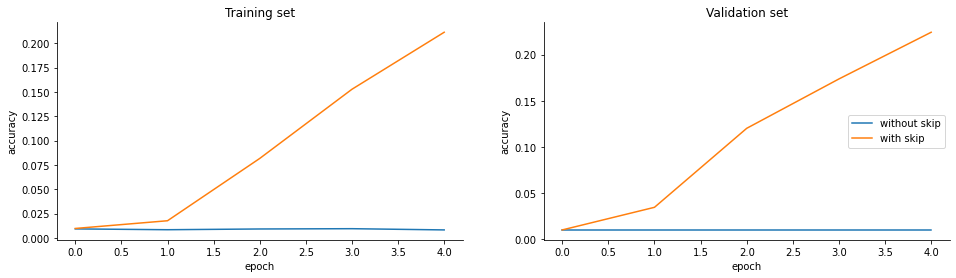

In [5]:
plt.figure(figsize=(16, 4))

ax = plt.subplot(121)
ax.plot(h1.history['accuracy'], c='C0', label='without skip (training)')
ax.plot(h2.history['accuracy'], c='C1', label='with skip (training)')
ax.set_title('Training set')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(h1.history['val_accuracy'], c='C0', label='without skip')
ax.plot(h2.history['val_accuracy'], c='C1', label='with skip')
ax.set_title('Validation set')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='center right')

Notice that without connections, this model was **completely untrainable**. 

**Important Note**: This example was made specifically to showcase the benefits of skip connections. To accomplish this we used a much larger network than necessary. In shallower networks skip connections aren't that helpful and might even hurt convergence.

### Residual connections

These are essentially skip connections that connect the *main* path to the *skip* path via **addition**. These connections were made popular through the [ResNet](https://arxiv.org/abs/1512.03385) architecture.

In [6]:
def make_cnn_with_residual(input_shape=(32, 32, 3), num_classes=100, residual_connections=True):

  inp = tf.keras.layers.Input(input_shape)

  c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)

  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)

  if residual_connections:
    c3 = tf.keras.layers.Add()([c1, c3])  # add c1 with c3
  
  c4 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(c3)

  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
  
  c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  
  if residual_connections:
    c6 = tf.keras.layers.Add()([c4, c6])  # add c4 with c6

  c7 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(c6)

  c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
  
  c9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
  
  if residual_connections:
    c9 = tf.keras.layers.Add()([c7, c9])  # add c7 with c9
  
  c10 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(c9)

  c11 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c10)
  
  c12 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c11)
  
  if residual_connections:
    c12 = tf.keras.layers.Add()([c10, c12])  # add c10 with c12

  c13 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(c12)

  c14 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c13)
  
  c15 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c14)
  
  if residual_connections:
    c15 = tf.keras.layers.Add()([c13, c15])  # add c13 with c15

  fl = tf.keras.layers.Flatten()(c15)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

Again, these two models have exactly the same number of layers ($16$) and parameters ($\approx 3.82$ mil)

In [7]:
cnn_without_res = make_cnn_with_residual(residual_connections=False)
print('Number of Parameters (no skip connections):  ', sum([np.prod(p.shape) for p in cnn_without_res.trainable_variables]))
h3 = cnn_without_res.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=512)

cnn_with_res = make_cnn_with_residual(residual_connections=True)
print('Number of Parameters (with skip connections):', sum([np.prod(p.shape) for p in cnn_with_res.trainable_variables]))
h4 = cnn_with_res.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=512)

Number of Parameters (no skip connections):   3828836
Epoch 1/5
98/98 [==============================] - 24s 243ms/step - loss: 4.6057 - accuracy: 0.0088 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 2/5
98/98 [==============================] - 22s 227ms/step - loss: 4.6054 - accuracy: 0.0092 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 3/5
98/98 [==============================] - 22s 226ms/step - loss: 4.6053 - accuracy: 0.0098 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 4/5
98/98 [==============================] - 22s 226ms/step - loss: 4.6053 - accuracy: 0.0096 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 5/5
98/98 [==============================] - 22s 226ms/step - loss: 4.6053 - accuracy: 0.0086 - val_loss: 4.6052 - val_accuracy: 0.0100
Number of Parameters (with skip connections): 3828836
Epoch 1/5
98/98 [==============================] - 24s 241ms/step - loss: 4.2385 - accuracy: 0.0539 - val_loss: 3.8267 - val_accuracy: 0.1145
Epoch 2/5
98/98 [=======================

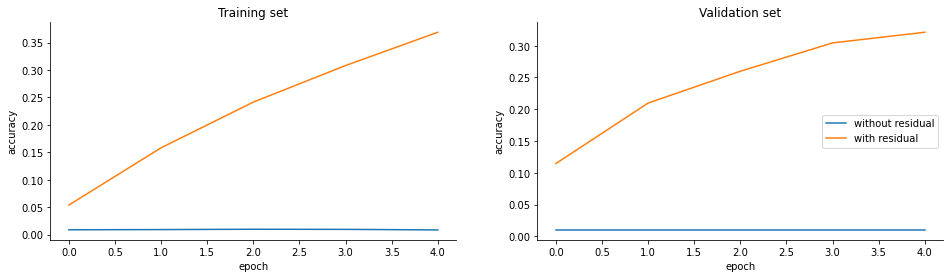

In [8]:
plt.figure(figsize=(16, 4))

ax = plt.subplot(121)
ax.plot(h3.history['accuracy'], c='C0', label='without residual (training)')
ax.plot(h4.history['accuracy'], c='C1', label='with residual (training)')
ax.set_title('Training set')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(h3.history['val_accuracy'], c='C0', label='without residual')
ax.plot(h4.history['val_accuracy'], c='C1', label='with residual')
ax.set_title('Validation set')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='center right')

Again, these connections are helpful in much deeper networks and this example was made specifically to showcase the benefit of these connections.

## Dropout

One of the most effective and popular regularization techniques in Neural Networks is [dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). This technique is applied to a layer in a network and randomly removes some of its activations in each iteration. Through this procedure, the subsequent layer becomes less dependent to each single activation and learns to better utilize the information provided to it, which improves the network's generalization.

!!!!!   IMAGE   !!!!!


In [9]:
def make_cnn_dropout(input_shape=(32, 32, 3), num_classes=10, dropout=True, dropout_perc=0.3):
  inp = tf.keras.layers.Input(input_shape)

  c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)

  if dropout:
    # Apply dropout to layer c1:
    c1 = tf.keras.layers.Dropout(dropout_perc)(c1)  # 0.5 is the probability that an activation
                                                    # is randomly ignored in each iteration 

  c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(c1)
  
  if dropout:
    c2 = tf.keras.layers.Dropout(dropout_perc)(c2)  # apply dropout to c2

  p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(c2)

  c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(p2)
  
  if dropout:
    c3 = tf.keras.layers.Dropout(dropout_perc)(c3)  # apply dropout to c3

  fl = tf.keras.layers.Flatten()(c3)

  d = tf.keras.layers.Dense(100)(fl)

  if dropout:
    d = tf.keras.layers.Dropout(dropout_perc)(d)  # apply dropout to d

  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

Like before, we'll use two identical models, one with and one without dropout.

In [36]:
cnn_without_dropout = make_cnn_dropout(dropout=False, num_classes=100)
print('Number of Parameters (no dropout):  ', sum([np.prod(p.shape) for p in cnn_without_dropout.trainable_variables]))
h1 = cnn_without_dropout.fit(x_train, y_train, validation_data=(x_test, y_test), 
                             epochs=15, batch_size=512)

cnn_with_dropout = make_cnn_dropout(dropout=True, num_classes=100, dropout_perc=0.4)
print('Number of Parameters (with dropout):  ', sum([np.prod(p.shape) for p in cnn_with_dropout.trainable_variables]))
h2 = cnn_with_dropout.fit(x_train, y_train, validation_data=(x_test, y_test),
                          epochs=15, batch_size=512)

Number of Parameters (no dropout):   1936548
Epoch 1/15
98/98 [==============================] - 6s 66ms/step - loss: 3.7461 - accuracy: 0.1459 - val_loss: 3.2742 - val_accuracy: 0.2328
Epoch 2/15
98/98 [==============================] - 6s 63ms/step - loss: 2.9585 - accuracy: 0.2909 - val_loss: 2.8779 - val_accuracy: 0.3058
Epoch 3/15
98/98 [==============================] - 6s 63ms/step - loss: 2.5365 - accuracy: 0.3739 - val_loss: 2.7214 - val_accuracy: 0.3396
Epoch 4/15
98/98 [==============================] - 6s 63ms/step - loss: 2.2040 - accuracy: 0.4464 - val_loss: 2.5958 - val_accuracy: 0.3679
Epoch 5/15
98/98 [==============================] - 6s 62ms/step - loss: 1.8844 - accuracy: 0.5146 - val_loss: 2.6386 - val_accuracy: 0.3746
Epoch 6/15
98/98 [==============================] - 6s 63ms/step - loss: 1.5814 - accuracy: 0.5867 - val_loss: 2.6586 - val_accuracy: 0.3849
Epoch 7/15
98/98 [==============================] - 6s 63ms/step - loss: 1.2796 - accuracy: 0.6606 - val_loss

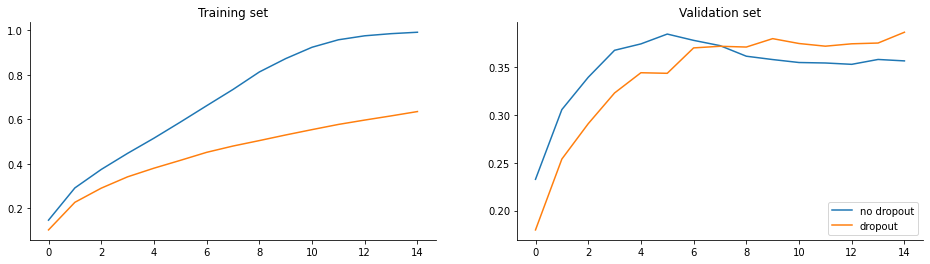

In [37]:
plt.figure(figsize=(16, 4))

ax = plt.subplot(121)
ax.plot(h1.history['accuracy'], c='C0', label='no dropout (training)')
ax.plot(h2.history['accuracy'], c='C1', label='dropout (training)')
ax.set_title('Training set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(h1.history['val_accuracy'], c='C0', label='no dropout')
ax.plot(h2.history['val_accuracy'], c='C1', label='dropout')
ax.set_title('Validation set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower right')

Notice the reguralizing effect of dropout, in the above figures. It reduces the model's performance on the training set, but it increases its performance on the validation set. 

Dropout is arguably more effecively applied to **Fully Connected** layers.

## Batch Normalization

Another immensely popular technique in Deep Neural Networks is Batch Normalization. The idea is to standardize the activations of a given layer in a Neural Network (much like we do with the input), so that the subsequent layer doesn't have to deal with the change in the distribution of its inputs over time. This effect is referred to by [the authors](https://arxiv.org/abs/1502.03167) as internal covariate shift and they speculate that it causes much of the problems in Neural Network training.

To scale a layer's activation, normally we'd have to know of its mean and standard deviation. Since these two values are unknown to us, we can only estimate them through a moving average. Thus, batch norm, computes the mean and standard deviation **of each feature map** (i.e. channel), over all the batches independently. This causes confusion some times, because of the name of the technique so it is important to note that BN **doens't** normalize each batch as its name implies, but each feature map$^{1}$! 

$^1$*Note*: normalizing each batch is actually another technique called [Layer Normalization](https://arxiv.org/abs/1607.06450).

Scaling the activations of a Layer is only half of the technique, though. The authors actually insert two **trainable** parameters into the procedure ($\gamma$ and $\beta$, representing the mean and std, respectively) to allow the network to decide the appropriate scale and shift for the activations. 

In [12]:
def make_cnn_bn(input_shape=(32, 32, 3), num_classes=100, bn=True):
  inp = tf.keras.layers.Input(input_shape)

  c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)

  if bn:
    c1 = tf.keras.layers.BatchNormalization()(c1)  # apply bn to c1

  c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(c1)
  if bn:
    c2 = tf.keras.layers.BatchNormalization()(c2)  # apply bn to c2

  p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(c2)

  c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(p2)
  if bn:
    c3 = tf.keras.layers.BatchNormalization()(c3)  # apply bn to c3

  fl = tf.keras.layers.Flatten()(c3)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [13]:
cnn_without_bn = make_cnn_bn(bn=False)
print('Number of Parameters (no BN):  ', sum([np.prod(p.shape) for p in cnn_without_bn.trainable_variables]))
h1 = cnn_without_bn.fit(x_train, y_train, validation_data=(x_test, y_test), 
                        epochs=10, batch_size=512, verbose=0)

cnn_with_bn = make_cnn_bn(bn=True)
print('Number of Parameters (with BN):  ', sum([np.prod(p.shape) for p in cnn_with_bn.trainable_variables]))
h2 = cnn_with_bn.fit(x_train, y_train, validation_data=(x_test, y_test),
                     epochs=10, batch_size=512, verbose=0)

Number of Parameters (no BN):   1936548
Number of Parameters (with BN):   1936996


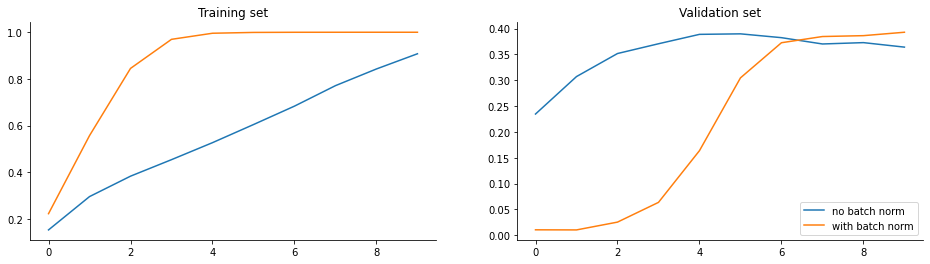

In [14]:
plt.figure(figsize=(16, 4))

ax = plt.subplot(121)
ax.plot(h1.history['accuracy'], c='C0', label='no batch norm (training)')
ax.plot(h2.history['accuracy'], c='C1', label='with batch norm (training)')
ax.set_title('Training set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(h1.history['val_accuracy'], c='C0', label='no batch norm')
ax.plot(h2.history['val_accuracy'], c='C1', label='with batch norm')
ax.set_title('Validation set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower right')

Notice how much faster and better the network is trained with BN. 

**Important note**: Theoretically, you should not apply BN after dropout, because the parameters won't be able to correctly estimate the mean and std of its inputs, due to the stochasticity induced by randomly dropping out some neurons at each iteration. In fact the BN's authors advocate for removing dropout altogether ([Pg. 6, Sec 4.2.1](https://arxiv.org/pdf/1502.03167.pdf)). This is a topic of debate in recent years, as many modern architectures tend to favor BN over dropout (e.g. ResNet, DenseNet). A more in-depth discussion on the disharmony of these two technique can be found [here](https://arxiv.org/pdf/1801.05134.pdf). We will explore this in more detail in the Appendix. 

## Data Augmentation

Deep Neural Networks usually improve with more data. Data augmentation is a technique for effectively increasing the size of the training set, without getting more data. This is done by generaing synthetic data from the actual ones and using these synthetic ones, in conjunction with the real, for training the network.

Data augmentation is very popular in image classification because its easy to implement and very intuitive. The idea here is to perturb the image in such a way that doesn't alter its semantic content, but seems like a different image to the network. A simple augmentation strategy is to flip an image.

(-0.5, 31.5, 31.5, -0.5)

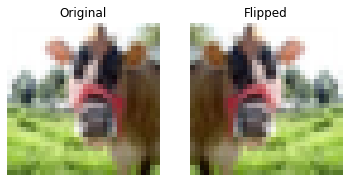

In [15]:
ax = plt.subplot(121)
ax.imshow(x_train[0])
ax.set_title('Original')
ax.axis('off')

ax = plt.subplot(122)
ax.imshow(x_train[0, :, ::-1])
ax.set_title('Flipped')
ax.axis('off')

Notice how both of these two are in fact two different images for the network, however they depict the same thing. The image in the right can be used for training the network!

Besides left-right and bottom-up flipping, other image augmentation techniques include:

- cropping an image by a certain percentage:

*Note: we are going to use [imgaug](https://github.com/aleju/imgaug) for applying these augmentations. We won't go into much detail about the library, as the focus will be on the idea of image augmentation rather than the implementation.*

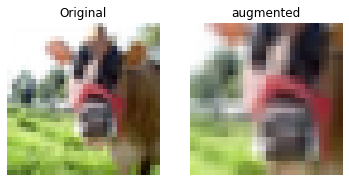

In [16]:
def show_augment(image, augmentors):

  seq = ia.augmenters.Sequential(augmentors)

  aug = seq(images=[image])
  ax = plt.subplot(121)
  ax.imshow(image)
  ax.set_title('Original')
  ax.axis('off')

  ax = plt.subplot(122)
  ax.imshow(aug[0])
  ax.set_title('augmented')
  ax.axis('off')

augmentors = [ia.augmenters.Crop(percent=(0.2, 0.2))]
show_augment(x_train[0], augmentors)

- Scaling an image by a certain percentage (note that this can be done independently in each dimension)

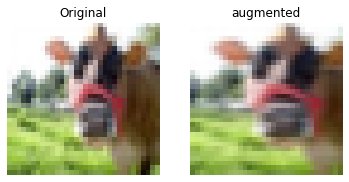

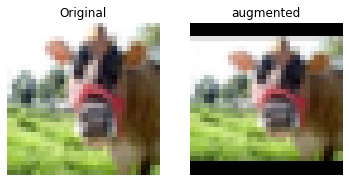

In [17]:
augmentors = [ia.augmenters.Affine(scale={'x': (1.4, 1.4), 'y': (1, 1)})]
show_augment(x_train[0], augmentors)

plt.figure()
augmentors = [ia.augmenters.Affine(scale={'x': (1, 1), 'y': (0.8, 0.8)})]
show_augment(x_train[0], augmentors)

- Translation (i.e. shift the image up/down or left/right)

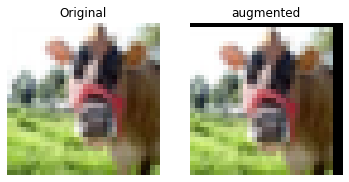

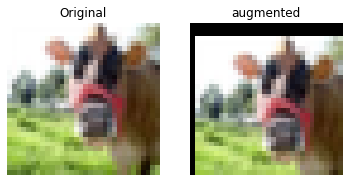

In [18]:
augmentors = [ia.augmenters.Affine(translate_percent={'x': (-0.05, -0.05), 'y': (1, 1)})]
show_augment(x_train[0], augmentors)

plt.figure()
augmentors = [ia.augmenters.Affine(translate_percent={'x': (1, 1), 'y': (0.1, 0.1)})]
show_augment(x_train[0], augmentors)

- Rotation

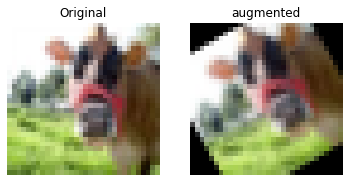

In [19]:
augmentors = [ia.augmenters.Affine(rotate=(-30, -30))]
show_augment(x_train[0], augmentors)

- Shear

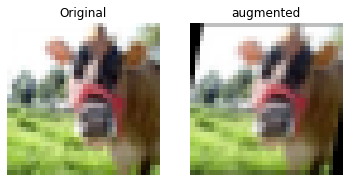

In [20]:
augmentors = [ia.augmenters.Affine(shear=(10, 10))]
show_augment(x_train[0], augmentors)

- Brightness adjustment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


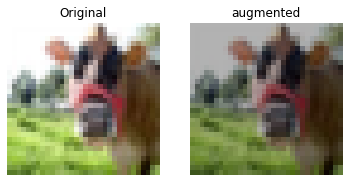

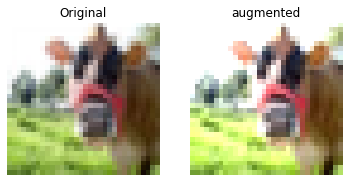

In [21]:
augmentors = [ia.augmenters.Multiply((0.7, 0.7), per_channel=0.2)]
show_augment(x_train[0], augmentors)

plt.figure()
augmentors = [ia.augmenters.Multiply((1.3, 1.3), per_channel=0.2)]
show_augment(x_train[0], augmentors)

- Contrast adjustment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


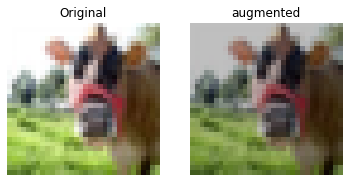

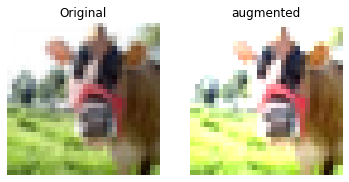

In [22]:
augmentors = [ia.augmenters.ContrastNormalization((0.75, 0.75))]
show_augment(x_train[0], augmentors)

plt.figure()
augmentors = [ia.augmenters.ContrastNormalization((1.5, 1.5))]
show_augment(x_train[0], augmentors)

- Blurring

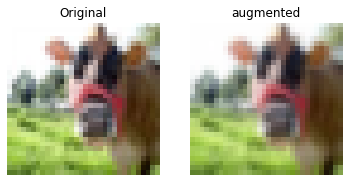

In [23]:
augmentors = [ia.augmenters.GaussianBlur(sigma=(0.5, 0.5))]
show_augment(x_train[0], augmentors)

- Adding random noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


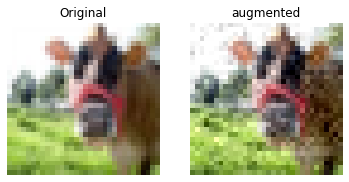

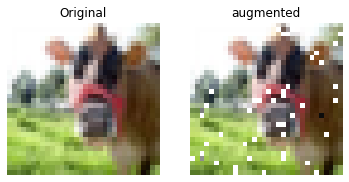

In [24]:
augmentors = [ia.augmenters.AdditiveGaussianNoise(loc=0, scale=(0.07, 0.07), per_channel=0.5)]
show_augment(x_train[0], augmentors)

plt.figure()
augmentors = [ia.augmenters.SaltAndPepper((0.05, 0.05))]
show_augment(x_train[0], augmentors)

And there are many many more image augmentation strategies.

Usually these augmentors are applied **randomly** to the images of each batch. 

Data augmentation helps in making the network's task harder, by making it impossible for the network to memorize the entire training set. Thus, it helps the network generalize better!

We need to be careful, though, because too much augmentation might alter the semantic content of an image! Unfortunately, augmentors and their parameters need to be specified ad-hoc for each application separately.

Let's see how augmentation works in practice. First, we'll define an augmentation scheme and see how it affects the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 127.5, -0.5)

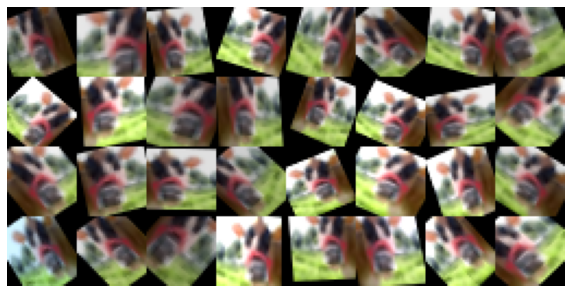

In [25]:
seq = ia.augmenters.Sequential([
        ia.augmenters.Fliplr(0.5),
        ia.augmenters.Crop(percent=(0, 0.2)),
        ia.augmenters.Sometimes(0.5, ia.augmenters.GaussianBlur(sigma=(0, 0.2))),
        ia.augmenters.ContrastNormalization((0.8, 1.2)),
        ia.augmenters.Multiply((0.8, 1.2), per_channel=0.2),
        ia.augmenters.Affine(
            scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)},
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            rotate=(-45, 45),
            shear=(-10, 10))], 
        random_order=True)

base = np.repeat(x_train[0][np.newaxis], 32, axis=0)
images_aug = seq(images=base)

tmp = np.concatenate([images_aug[:8], images_aug[8:16], images_aug[16:24], images_aug[24:32]], axis=1)
collage = np.concatenate([tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5], tmp[6], tmp[7]], axis=1)


plt.figure(figsize=(10, 10))
plt.imshow(collage)
ax = plt.gca()
ax.axis('off')

The easiest way to use these augmentors is through the `ImageDataGenerator` we saw previously.

In [26]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=seq.augment_image).flow(x_train, y_train, batch_size=256)
x, y = next(gen)
x.shape, y.shape

((256, 32, 32, 3), (256, 100))

Another option would be to use the `tf.data.Dataset.map()` method to apply the augmentors to each image. 

*Note:* Training with augmentation typically increases the training time required for your networks.

## Appendix

### A. Dropout vs Batch Normalization

Here we'll run a few experiments to compare *naively*$^2$ combining these two components.

$^2$By this I mean simply adding these two as layers and not modifying any of these components.

**Warning**: this will take a while

In [27]:
def make_cnn_adb(input_shape=(32, 32, 3), num_classes=100):
  """
  ADB = Activation --> Dropout --> BN
  """
  inp = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  fl = tf.keras.layers.Flatten()(x)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

def make_cnn_abd(input_shape=(32, 32, 3), num_classes=100):
  """
  ADB = Activation --> BN --> Dropout
  """
  inp = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  fl = tf.keras.layers.Flatten()(x)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

def make_cnn_bad(input_shape=(32, 32, 3), num_classes=100):
  """
  BAD = BN --> Activation --> Dropout
  """
  inp = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(32, (3, 3))(inp)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Conv2D(64, (3, 3))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = tf.keras.layers.Conv2D(128, (3, 3))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  fl = tf.keras.layers.Flatten()(x)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

def make_cnn_dab(input_shape=(32, 32, 3), num_classes=100):
  """
  DAB = Dropout --> Activation --> BN
  """
  inp = tf.keras.layers.Input(input_shape)

  x = tf.keras.layers.Conv2D(32, (3, 3))(inp)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(64, (3, 3))(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, (3, 3))(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.BatchNormalization()(x)

  fl = tf.keras.layers.Flatten()(x)
  out = tf.keras.layers.Dense(num_classes, activation='softmax')(fl)

  model = tf.keras.models.Model(inp, out)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

Warning: this will take a while...


In [28]:
cnn_adb = make_cnn_adb()
h1 = cnn_adb.fit(x_train, y_train, validation_data=(x_test, y_test), 
                 epochs=20, batch_size=512)

cnn_abd = make_cnn_abd()
h2 = cnn_abd.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=20, batch_size=512)

cnn_bad = make_cnn_bad()
h3 = cnn_bad.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=20, batch_size=512)

cnn_dab = make_cnn_dab()
h4 = cnn_dab.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=20, batch_size=512)


Epoch 1/20
98/98 [==============================] - 20s 202ms/step - loss: 5.7132 - accuracy: 0.0992 - val_loss: 6.7486 - val_accuracy: 0.0154
Epoch 2/20
98/98 [==============================] - 19s 194ms/step - loss: 5.5716 - accuracy: 0.1734 - val_loss: 8.2723 - val_accuracy: 0.0100
Epoch 3/20
98/98 [==============================] - 19s 194ms/step - loss: 4.6567 - accuracy: 0.2245 - val_loss: 11.7974 - val_accuracy: 0.0100
Epoch 4/20
98/98 [==============================] - 19s 194ms/step - loss: 3.7991 - accuracy: 0.2804 - val_loss: 7.2237 - val_accuracy: 0.0196
Epoch 5/20
98/98 [==============================] - 19s 194ms/step - loss: 3.3747 - accuracy: 0.3134 - val_loss: 5.7712 - val_accuracy: 0.0521
Epoch 6/20
98/98 [==============================] - 19s 193ms/step - loss: 3.0621 - accuracy: 0.3569 - val_loss: 3.9413 - val_accuracy: 0.1692
Epoch 7/20
98/98 [==============================] - 19s 193ms/step - loss: 2.7423 - accuracy: 0.3958 - val_loss: 3.2558 - val_accuracy: 0.257

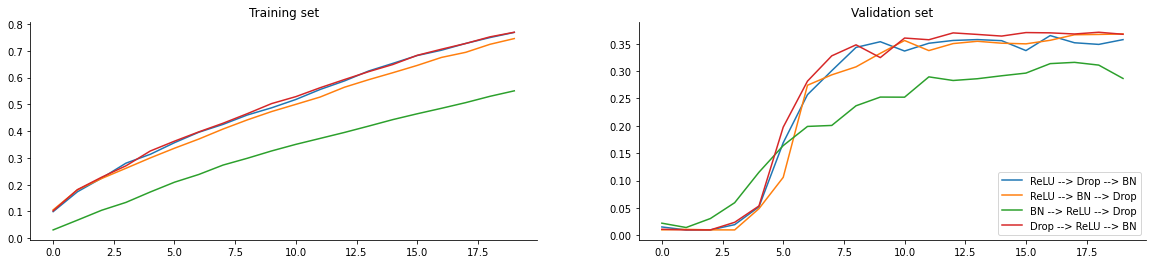

In [29]:
plt.figure(figsize=(20, 4))

ax = plt.subplot(121)
ax.plot(h1.history['accuracy'], c='C0', label='ReLU --> Drop --> BN')
ax.plot(h2.history['accuracy'], c='C1', label='ReLU --> BN --> Drop')
ax.plot(h3.history['accuracy'], c='C2', label='BN --> ReLU --> Drop')
ax.plot(h4.history['accuracy'], c='C3', label='Drop --> ReLU --> BN')
ax.set_title('Training set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(h1.history['val_accuracy'], c='C0', label='ReLU --> Drop --> BN')
ax.plot(h2.history['val_accuracy'], c='C1', label='ReLU --> BN --> Drop')
ax.plot(h3.history['val_accuracy'], c='C2', label='BN --> ReLU --> Drop')
ax.plot(h4.history['val_accuracy'], c='C3', label='Drop --> ReLU --> BN')
ax.set_title('Validation set')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower right')

Interestingly, most configurations exhibit a similar performance. Apparently, only one we should avoid is BN --> ReLU --> Dropout.